# 🧬 Clustering de cellules cancéreuses
Nous allons utiliser des méthodes de réduction de dimension (PCA) et de clustering (k-means) afin de regrouper des cellules cancéreuses (issues de sous-types de cancer distincts) en fonction de leur expression génique. 

# 💾 Données

> L'ensemble de donnée (dataset) que nous allons utiliser contient les valeurs d'expression génique de cellules cancéreuses. Ces données sont extraites d'un manuscrit rédigé par les chercheurs du projet d'analyse pan-cancéreuse The Cancer Genome Atlas (TCGA).
 
> Il y a 881 échantillons (lignes) représentant 5 sous-types de cancer distincts. Chaque échantillon comporte les valeurs d'expression génique pour 20 531 gènes (colonnes). L'ensemble de données est disponible sur le UC Irvine Machine Learning Repository.

# 📤 Import des Librairies

In [1]:
import tarfile
import urllib

import pandas as pd # Analyse et manipulation de données (utilisation des Panda DataFrame) https://pandas.pydata.org/docs/user_guide/index.html and/or https://sparkbyexamples.com/python-pandas-tutorial-for-beginners/ 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Visualization de données
#import hvplot.pandas # Plots interactifs https://hvplot.holoviz.org/

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

%matplotlib inline

# Téléchargement et extraction du dataset

In [2]:
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# URL
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Télécharger le fichier
r = urllib.request.urlretrieve (full_download_url, archive_name)

# Extraire les données de l'archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

In [3]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

# Charger les données du fichier 'datafile'
data = np.genfromtxt(
    datafile,
    delimiter=",",
    usecols=range(1, 20532),
    skip_header=1
)

# Charger les étiquettes du fichier 'labels_file'
true_label_names = np.genfromtxt(
    labels_file,
    delimiter=",",
    usecols=(1,),
    skip_header=1,
    dtype="str"
)

Vérifions la taille des données; i.e.,
- Nombre d'échantillons (Nombre de lignes)
- Nombre de gènes (Nombre de colonnes)

In [4]:
data.shape

(801, 20531)

**Instruction**: Vérifiez que le nombre d'étiquettes est consitent avec le nombre d'échantillons

<details>
<summary>Aide</summary>
utilisez numpy.shape
</details>

In [5]:
# Code ici
true_label_names.shape

(801,)

Consultons les premières lignes et colonnes des données

In [6]:
data[:5,:3]

array([[0.        , 2.01720929, 3.26552691],
       [0.        , 0.59273209, 1.58842082],
       [0.        , 3.51175898, 4.32719872],
       [0.        , 3.66361787, 4.50764878],
       [0.        , 2.65574107, 2.82154696]])

**instruction** Consultez les étiquettes des 5 premiers échantillons

<details>
<summary>Aide</summary>
Ce sont les 5 premiers éléments de `true_label_names`
</details>


In [7]:
# Code ici
true_label_names[:5]

array(['PRAD', 'LUAD', 'PRAD', 'PRAD', 'BRCA'], dtype='<U4')

In [8]:
# Valeurs uniques dans le tableau des étiquettes de référence
np.unique(true_label_names)

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype='<U4')

# Convertir les abréviations en entiers avec LabelEncoder

In [9]:
# Encode les étiquettes avec des valeurs entre 0 et le nombre de classes
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(true_label_names)
true_labels[:5]

array([4, 3, 4, 4, 0])

In [10]:
# Étant donné que l'encodeur a été ajusté aux données, vous pouvez voir les classes uniques représentées en utilisant .classes_.label_encoder.classes_
label_encoder.classes_

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype='<U4')

**Instruction**: Fixer le nombre de clusters aux nombres de classes uniques représentées
<details>
<summary>Aide</summary>
Vous pouvez utiliser la fonction `len(...)`
</details>

In [11]:
# Code ici
n_clusters = len(label_encoder.classes_)

#  Pipeline
## Pipeline pour traiter les données

**Instruction**: Fixez le nombre de composantes principales à 2 pour la méthode PCA
<details>
<summary>Aide</summary>
Indiquez l'argument `n_components`
</details>

In [12]:
# Normalisation et réduction de dimension
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        # Code ici
        ("pca", PCA(n_components=2, random_state=42))
    ]
)

## Pipeline pour effectuer le clustering K-means

In [13]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

## Enchaîner les pipelines de prétraitement et de clustering

In [14]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

## Appliquer les étapes du pipeline sur les données

In [15]:
pipe.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

In [16]:
# Vérifie le résultat de la réduction de dimension
preprocessed_data = pipe["preprocessor"].transform(data)
preprocessed_data[:5,:]


array([[ -5.66814062,  -8.87213883],
       [ -1.47020396,  10.28018174],
       [-10.84538683,  -1.34535227],
       [ -9.16796109,  -8.67012314],
       [ -6.27184805,  -3.10120752]])

In [17]:
# Vérifie le résultat du clustering
predicted_labels = pipe["clusterer"]["kmeans"].labels_
predicted_labels[:5]

array([1, 4, 3, 1, 3], dtype=int32)

# Évaluer la qualité du clustering

**Instruction**: Calculez le coefficient de silhouette en fonction des données réduites `preprocessed_data` et des clusters attribués `predicted_labels` 
<details>
<summary>Aide</summary>
Utilisez la fonction `silhouette_score(...)`
</details>

In [18]:
# Code ici
silhouette_score(preprocessed_data, predicted_labels)

0.5118775528450284

Profitons d'avoir les étiquettes de référence pour calculer une deuxième mesure de qualité du clustering :) 

**Instruction**: Calculez l'Indice de Rand Ajusté (ARI) en fonction des étiquettes de référence `true_labels` et des clusters attribués `predicted_labels` 
<details>
<summary>Aide</summary>
Utilisez la fonction `adjusted_rand_score(...)`
</details>

In [19]:
# Code ici
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

# Visualiser les données dans le contexte des étiquettes réelles et des étiquettes prédites

In [20]:
# Construit le data frame avec la projection des données en 2D, leurs clusters prédits, et leurs étiquettes de référence
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data)[:,:2],
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)
pcadf.head()

,component_1,component_2,predicted_cluster,true_label
0,-5.668141,-8.872139,1,PRAD
1,-1.470204,10.280182,4,LUAD
2,-10.845387,-1.345352,3,PRAD
3,-9.167961,-8.670123,1,PRAD
4,-6.271848,-3.101208,3,BRCA


/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

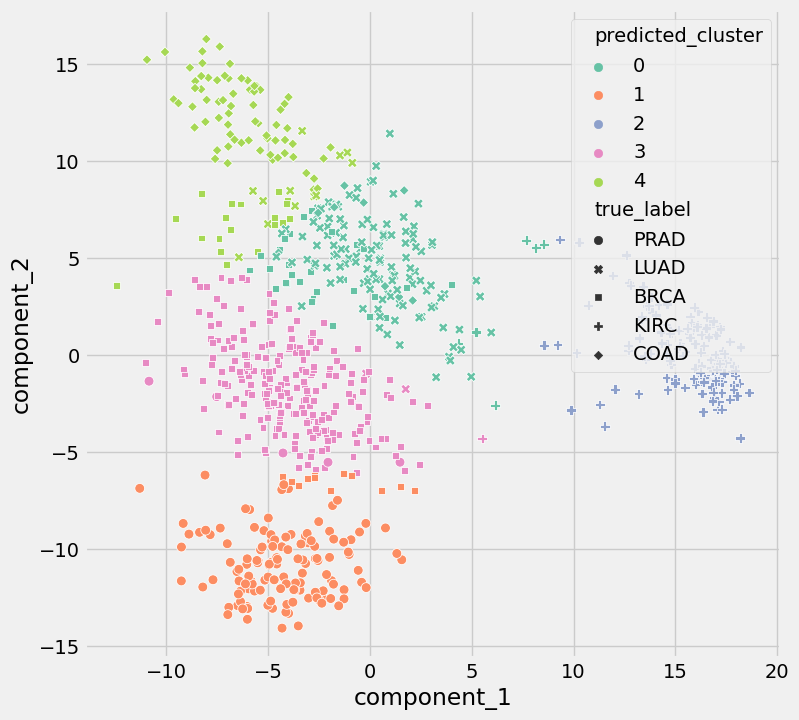

In [21]:
# Plot
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    data=pcadf,
    x = "component_1",
    y = "component_2",
    s=50,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

# Réglage des paramètres
Utilisez les la variance expliquée cumulée pour identifier le nombre approprié de composantes principales à garder.

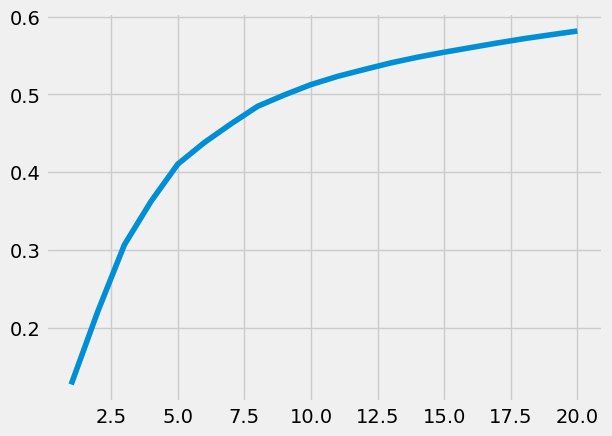

In [22]:
# Récupére et visualise la variance expliquée cumulée par les 20 premières composantes
m = 20
pipe["preprocessor"]["pca"].n_components = m
pipe.fit(data)
pipe["preprocessor"]["pca"].explained_variance_
plt.plot(
    range(1, m+1),
    np.cumsum(pipe["preprocessor"]["pca"].explained_variance_ratio_))

Enfin, utilisons les métriques de qualité de clustering pour définir le nombre clusters

**Instruction**: 
- Fixez le nombre de composantes principales `n_components` à 7
- Faites varier le nombre de clusters `n_clusters` de 2 à 10
<details>
<summary>Aide</summary>

- Vous pouvez accéder aux hyperparamètre de la PCA, à travers `pipe["preprocessor"]["pca"]`

- Vous pouvez accéder aux hyperparamètre de K-means clustering, à travers `pipe["clusterer"]["kmeans"]`
</details>

In [23]:
# Listes vides pour stocker les métriques de qualité 
# Silhouette
silhouette_scores = []
# Index Rand Ajusté
ari_scores = []
for n in range(2, 11):
    # On fait varier le nombre de clusters,
    # en laissant les autres paramètres inchangées, e.g. nombre de composantes principales
    ### Code ici - Début ###
    pipe["preprocessor"]["pca"].n_components = 7
    pipe["clusterer"]["kmeans"].n_clusters = n
    ### Code ici - Fin ###
    pipe.fit(data)

    silhouette_coef = silhouette_score(
        pipe["preprocessor"].transform(data),
        pipe["clusterer"]["kmeans"].labels_,
    )
    ari = adjusted_rand_score(
        true_labels,
        pipe["clusterer"]["kmeans"].labels_,
    )

    # Ajoute les métriques aux listes correspondantes
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)

# Visualisez la relation entre le nombre de clusters et la qualité du clustering

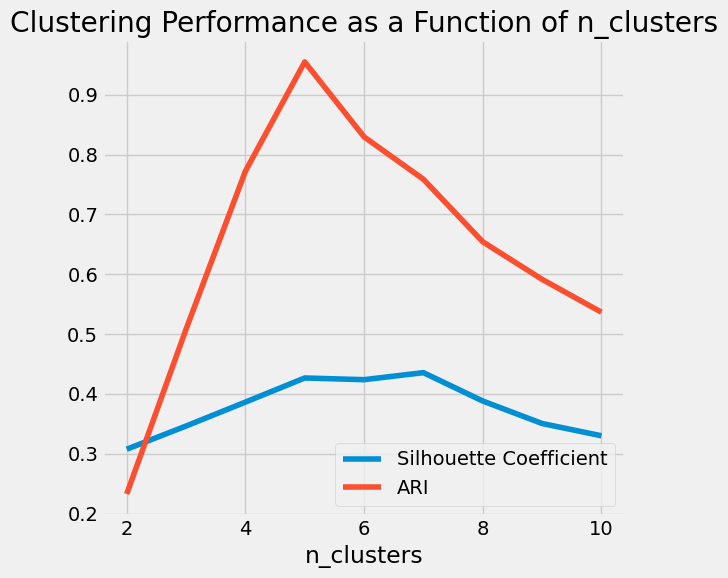

In [25]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
plt.plot(
    range(2, 11),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
plt.plot(range(2, 11), ari_scores, c="#fc4f30", label="ARI")

plt.xlabel("n_clusters")
plt.legend()
plt.title("Clustering Performance as a Function of n_clusters")
plt.tight_layout()
plt.show()


# 📝 Résumé
Dans ce notebook, vous avez utilisé des méthodes de dimension de réduction et de clustering pour le regroupement automatique de cellules cancéreuses.

Vous avez couvert les aspects suivants:
> - Le modèle de réduction de dimension PCA
> - Le modèle de clustering K-means
> - L'exploration et la préparation des données avant leur utilisation pour la réduction de dimension et le clustering
> - L'entrainement des deux modèles PCA et K-means
> - L'exploration des hyperparamètres des deux modèles, i.e., nombre de composantes principales, et nombre de clusters
> - L'évaluation de la qualité du clustering à l'aide du coefficient Silhouette et Score de Rand Ajusté 


# 🔗 References:
- [Scikit-learn library - Clustering](https://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering in Python: A Practical Guide](https://realpython.com/k-means-clustering-python/)
- [How to Select the Best Number of Principal Components for the Dataset](https://towardsdatascience.com/how-to-select-the-best-number-of-principal-components-for-the-dataset-287e64b14c6d)